In [1]:
# This part is required to be run in Google Colab as it does not have lunar lander continuous pre installed on it.
!pip install gym
!pip install "gym[box2d]"

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import random
import copy

In [ ]:
####### Ornstein-Uhlenbeck process #######

In [0]:
class OU:
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [0]:
noise = OU((1,1),0) ### defining the noise

In [5]:
noise.sample()[0]

array([0.13295834])

In [6]:
env = gym.make('MountainCarContinuous-v0')
# env = gym.make('LunarLanderContinuous-v2')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
state = env.reset()

In [0]:
device = 'cuda:0'  ##### GPU device is used as it was available on colab

In [9]:
torch.autograd.set_detect_anomaly(True)

In [0]:
######## function to copy parameters from one model to another similar model ########

In [0]:
def copy_params(model1, model2):
  for a,b in zip(model1.parameters(),model2.parameters()):
    b.data = copy.deepcopy(a.data)

In [ ]:
##### funciton implementing soft update of target functions #####

In [0]:
def soft_update(local_model, target_model, tau):
  for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
    target_param.data = copy.deepcopy(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
#### function to update the paramters of the network using DDPG ####

In [0]:
def update_params(D):
  pol1.zero_grad()
  Q1.zero_grad()
  pol2.zero_grad()
  Q2.zero_grad()
  ind = np.random.choice(range(len(D)), min(128,len(D)), replace=False)  ### 128 instances from experience are chosen
  t = 0
  d = []
  for i in ind:
    s1 = torch.Tensor(D[i][0]).to(device)
    a1 = D[i][1].detach()
    r = D[i][2]
    s2 = torch.Tensor(D[i][3]).to(device)
    d.append(D[i][4])
    if(t==0):
      state2 = s2.unsqueeze(dim=0)
      state1 = s1.unsqueeze(dim=0)
      act1 = a1.unsqueeze(dim=0)
      rew = torch.Tensor([r])
      t=1
    else:
      state2 = torch.cat([state2,s2.unsqueeze(dim=0)],dim = 0)
      state1 = torch.cat([state1,s1.unsqueeze(dim=0)],dim = 0)
      act1 = torch.cat([act1,a1.unsqueeze(dim=0)],dim = 0)
      rew = torch.cat([rew,torch.Tensor([r])])
  


  state2 = state2.to(device)
  act1 = act1.to(device)
  rew = rew.to(device)
  done = torch.Tensor(d).to(device)

  act2 = pol2(state2)
  # print("s1",state1.shape)
  # print("act1",act1.shape)
  # print("rew",rew.shape)
  # print("s2",state2.shape)
  # print("act2",act2.shape)
  # print("done",done.shape)
  y = rew.reshape([rew.shape[0],1]) + 0.99*Q2(state2,act2)*(1-done.reshape([done.shape[0],1]))
  q = Q1(state1,act1)
  loss1 = F.mse_loss(q,y)
  # print("loss1",loss1)
  opt1.zero_grad()
  loss1.backward()
  opt1.step()
  
  act3 = pol1(state1)
  loss2 = -1*Q1(state1,act3).mean()
  # print("loss2",loss2)
  opt2.zero_grad()
  loss2.backward()
  opt2.step()

  soft_update(Q1, Q2, TAU)
  soft_update(pol1, pol2, TAU) 

  return loss1

In [0]:
class Q_net(nn.Module):
  def __init__(self, state_size, action_size):
    super(Q_net, self).__init__()
    self.fcs1 = nn.Linear(state_size, 40)
    self.fc2 = nn.Linear(40+action_size, 30)
    self.fc3 = nn.Linear(30, 1)

  def forward(self, state, action):
    xs = F.relu(self.fcs1(state))
    x = torch.cat((xs, action), dim=1)
    x = F.relu(self.fc2(x))
    return self.fc3(x)

In [14]:
TAU = 1e-3

pol1 = nn.Sequential(nn.Linear(2,20),nn.ReLU(),nn.Linear(20,15),nn.ReLU(),nn.Linear(15,1),nn.Tanh()).to(device)
pol2 = nn.Sequential(nn.Linear(2,20),nn.ReLU(),nn.Linear(20,15),nn.ReLU(),nn.Linear(15,1),nn.Tanh()).to(device)
copy_params(pol1,pol2)
# pol1 is the local actor, pol2 is the target actor


Q1 = Q_net(2,1).to(device)
Q2 = Q_net(2,1).to(device)
copy_params(Q1,Q2)
# Q1 is the local critic, Q2 is the target critic

opt1 = torch.optim.Adam(Q1.parameters(),lr = 0.01)
opt2 = torch.optim.Adam(pol1.parameters(),lr = 0.001)
R = []
D = []
for episode in range(0,400):
  state = env.reset()
  done = False
  r = 0
  noise.reset()
  while(done!=True):
    if(len(D)>=50000):  #### maximum buffer size is 50000
      D = []
    for k in range(0,128):    ### batch size is 128
      pol1.zero_grad()
      Q1.zero_grad()
      action = pol1(torch.Tensor(state).to(device)) 
      N = noise.sample()[0]
      # a = [np.clip(action[0].item()+N[0],-1,1),np.clip(action[1].item()+N[1],-1,1)]
      a = [np.clip(action.item()+N,-1,1)]
      state1,reward,done,_ = env.step(a[0])
      D.append([state,action,reward,state1,done])
      if(len(D)>=64):
        loss = update_params(D)
      state = copy.deepcopy(state1)
      r+=reward
      if(done==True):
        break;
  R.append(r)
  print("Episode ",episode,"Reward",r,"R",sum(R)/len(R))  ### R that is being printed in the average reward so far

Episode  0 Reward -20.28512235353142 R -20.28512235353142
Episode  1 Reward -14.974891786079006 R -17.630007069805213
Episode  2 Reward -15.51350897217144 R -16.92450770392729
Episode  3 Reward -13.6864395711053 R -16.11499067072179
Episode  4 Reward -14.621038364839753 R -15.816200209545382
Episode  5 Reward -17.191050810962153 R -16.045341976448178
Episode  6 Reward -14.837743096432193 R -15.872827850731609
Episode  7 Reward -10.772586561629808 R -15.235297689593883
Episode  8 Reward -13.658959586351616 R -15.060149011455856
Episode  9 Reward -13.284049292574403 R -14.882539039567709
Episode  10 Reward -14.49638331952751 R -14.847433974109508
Episode  11 Reward -11.91303222776547 R -14.602900495247505
Episode  12 Reward -13.424223225722079 R -14.512233012976319
Episode  13 Reward -11.899157668477672 R -14.325584774083557
Episode  14 Reward -15.2064676751449 R -14.38431030082098
Episode  15 Reward -13.211771669214231 R -14.31102663634556
Episode  16 Reward -12.63160872151646 R -14.212

In [0]:
###### plotting the episodic reward ######

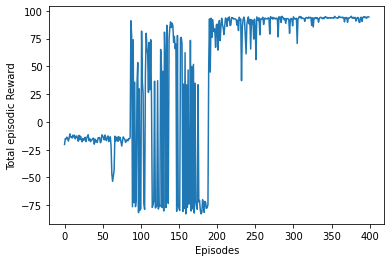

In [5]:
plt.plot(R)
plt.xlabel("Episodes")
plt.ylabel("Total episodic Reward")
plt.show()